In [138]:
# Necessary imports
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import glob
import re
from IPython.core.display import display, HTML
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

print('Libraries imported!')

Libraries imported!


In [141]:
df = pd.read_csv('../data/filtered_data.csv', index_col=0)
df.head()

,Name,Description,Full_Review,Tasting_Info
0,Mezcal de Leyendas Verde San Luis Potosi Mezca...,Mezcal de Leyendas Review Verde San Luis Potos...,"Clear color. Aromas and flavors of cucumber, m...","Fruity, Funky, Rich, Spicy, Smoky, Herbal & Co..."
1,El Tesoro Paradiso Tequila Extra Anejo Mexico ...,El Tesoro Review Paradiso Tequila Extra Anejo ...,"Gold color. Inviting aromas of roasted nuts, c...","Fruity, Complex, Candied, Herbal, Rich & Spicy..."
2,Peloton de la Muerte Vegan Pechuga Mezcal Mexi...,Peloton de la Muerte Review Vegan Pechuga Mezc...,Silvery straw color. Citrusy aromas and flavor...,"Complex, Fruity & Herbal | pickled melon and p..."
3,El Tesoro Anejo Tequila Mexico Spirits,El Tesoro Review Anejo Tequila Mexico Mexican ...,Straw color. Inviting aromas and flavors of ho...,"Fruity, Spicy & Herbal | honey-drizzled grapef..."
4,1800 Milenio Extra Anejo Tequila Mexico Spirits,1800 Review Milenio Extra Anejo Tequila Mexico...,"Amber color. Aromas of toffee coated popcorn, ...","Fruity, Rich & Spicy | toffee coated popcorn, ..."


In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8319 entries, 0 to 8318
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Name          8319 non-null   object
 1   Description   8319 non-null   object
 2   Full_Review   7274 non-null   object
 3   Tasting_Info  8319 non-null   object
dtypes: object(4)
memory usage: 325.0+ KB


## Review topic modeling

In [148]:
import random

random.seed(42)

sw = ['color', 'colors', 'aroma', 'aromas', 'flavor', 'flavors', 'review']
stop_words = ENGLISH_STOP_WORDS.union(sw)

In [159]:
def text_cleaning(texts):
    #lowercase
    texts = texts.apply(lambda x: x.lower())

    #Remove puntuations
    texts = texts.apply(lambda x: re.sub(r'[^\w\s]','',x))

    #Remove numbers
    texts = texts.apply(lambda x: re.sub(r'\d+', '', x))
    
    return texts

def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 20})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=25)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [150]:
reviews = df['Full_Review'].fillna(value='')

reviews = text_cleaning(reviews)

tfidf = TfidfVectorizer(max_df=0.5, stop_words=stop_words)

reviews_matrix = tfidf.fit_transform(reviews)

reviews_vocabs = tfidf.get_feature_names()

In [151]:
for review in reviews.sample(5).values:
    print(review)
    print('\n')




silvery emerald straw color artificial aromas and flavors of baked nectarine praline and green apple and pear with a supple vibrant effervescent medium body and a smooth interesting mediumlength finish with suggestions of lemon and kiwi relish tangerine shrub almond cookie and hint of rubber leaf a very tasty and appetizing cava that is a fine example of the category cava is a term that refers to spanish sparkling wine the word means cave or cellar while it is used for bubblies across the country most examples come from catalonia in the penedes region in northeast spaincava is produced according to the classic method used in champagne although aging requirements are much shorter while a few producers use chardonnay and pinot noir the most common varieties in cava are macabeo paralleda white and monastrell red cava can be made as a white or rosé the latter category is produced with the addition of red winemost examples of cava are valueoriented costing between  and  on us retail shel

### NMF

In [152]:
nmf_review = NMF(n_components=10)

nmf_review.fit(reviews_matrix)

reviews_matrix = nmf_review.transform(reviews_matrix)

reviews_df = pd.DataFrame(reviews_matrix).add_prefix('topic_')

reviews_df['Full_Review'] = reviews

reviews_df.head(10)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,Full_Review
0,0.001723,0.003874,0.001517,0.001736,0.001243,0.005546,0.012917,0.025821,0.00000,0.017839,clear color aromas and flavors of cucumber mel...
1,0.003806,0.021215,0.000089,0.000000,0.006104,0.004337,0.016366,0.026499,0.00000,0.007236,gold color inviting aromas of roasted nuts can...
2,0.002821,0.002729,0.002227,0.001111,0.002904,0.016430,0.002051,0.026855,0.00000,0.016449,silvery straw color citrusy aromas and flavors...
3,0.000000,0.025080,0.000000,0.003938,0.004343,0.010654,0.073131,0.016254,0.00000,0.000000,straw color inviting aromas and flavors of hon...
4,0.003806,0.018294,0.000582,0.000000,0.004499,0.007932,0.015965,0.021293,0.00000,0.009304,amber color aromas of toffee coated popcorn pe...
5,0.001644,0.001084,0.000000,0.000000,0.002686,0.008179,0.005980,0.026720,0.00518,0.018751,clear color savory aromas and flavors of marin...
6,0.000000,0.004375,0.001126,0.003489,0.001464,0.003881,0.013351,0.024271,0.00000,0.018787,clear color savory aromas of sweet chili sauce...
7,0.004200,0.020030,0.000116,0.001484,0.005107,0.005046,0.013294,0.021641,0.00000,0.007246,straw yellow color savory aromas and flavors o...
8,0.003594,0.022189,0.000000,0.000000,0.006780,0.004431,0.021571,0.024880,0.00000,0.009390,amber color aromas of molasses roasted figs ho...
9,0.000000,0.004999,0.001210,0.000947,0.000763,0.004202,0.013280,0.024540,0.00000,0.018699,clear color aromas of sweet tea gunpowder gril...


In [154]:
reviews_word_df = pd.DataFrame(nmf_review.components_.round(5), columns=reviews_vocabs).T.add_prefix('topic_')

reviews_word_df.head(10)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
abbey,0.00000,0.00013,0.00000,0.00000,0.00003,0.00014,0.00013,0.00084,0.00000,0.00037
abbreviated,0.00000,0.00047,0.00000,0.00000,0.00008,0.00107,0.00106,0.00193,0.00000,0.00098
abc,0.00002,0.00002,0.00000,0.00000,0.00002,0.00004,0.00004,0.00012,0.00001,0.00002
ability,0.00128,0.00009,0.00000,0.00071,0.00000,0.00153,0.00040,0.00243,0.00455,0.00000
abound,0.00370,0.00000,0.00006,0.00329,0.00175,0.00020,0.00092,0.00013,0.00075,0.00185
abounding,0.00004,0.00000,0.00004,0.00019,0.00104,0.00000,0.00000,0.00060,0.00032,0.00000
abrasive,0.00000,0.00018,0.00000,0.00041,0.00018,0.00076,0.00113,0.00254,0.00006,0.00161
abruzzo,0.00648,0.00173,0.00228,0.00000,0.01060,0.00000,0.00000,0.01398,0.00386,0.00000
absent,0.00000,0.00004,0.00000,0.00008,0.00000,0.00006,0.00006,0.00019,0.00000,0.00008
absinthe,0.00046,0.00000,0.00000,0.00000,0.00000,0.00173,0.00221,0.00254,0.00000,0.00575


In [155]:
display_topics(nmf_review, reviews_vocabs, 10)


Topic  0
sauvignon, cabernet, black, bordeaux, regions, wines, countries, rich, red, variety

Topic  1
chardonnay, burgundy, aged, small, california, barrels, richness, home, spicy, style

Topic  2
pinot, noir, noirs, burgundy, red, climate, tannins, tend, notes, valley

Topic  3
rosé, wine, salmon, southern, pink, versions, red, provence, rosés, italyoften

Topic  4
varietals, zinfandel, red, uncommon, like, old, grape, category, grown, plantings

Topic  5
blanc, herbal, sauvignon, sancerre, character, zealand, especially, styles, new, gooseberry

Topic  6
bourbon, whiskey, kentucky, rye, whiskies, states, pennsylvania, century, new, american

Topic  7
sparkling, wines, wine, sweet, prosecco, champagne, method, dessert, moscato, riesling

Topic  8
merlot, cabernet, bordeaux, sauvignon, franc, walla, best, red, powerful, wine

Topic  9
gin, gins, spirit, vodka, base, juniper, botanicals, flavored, berries, wheat


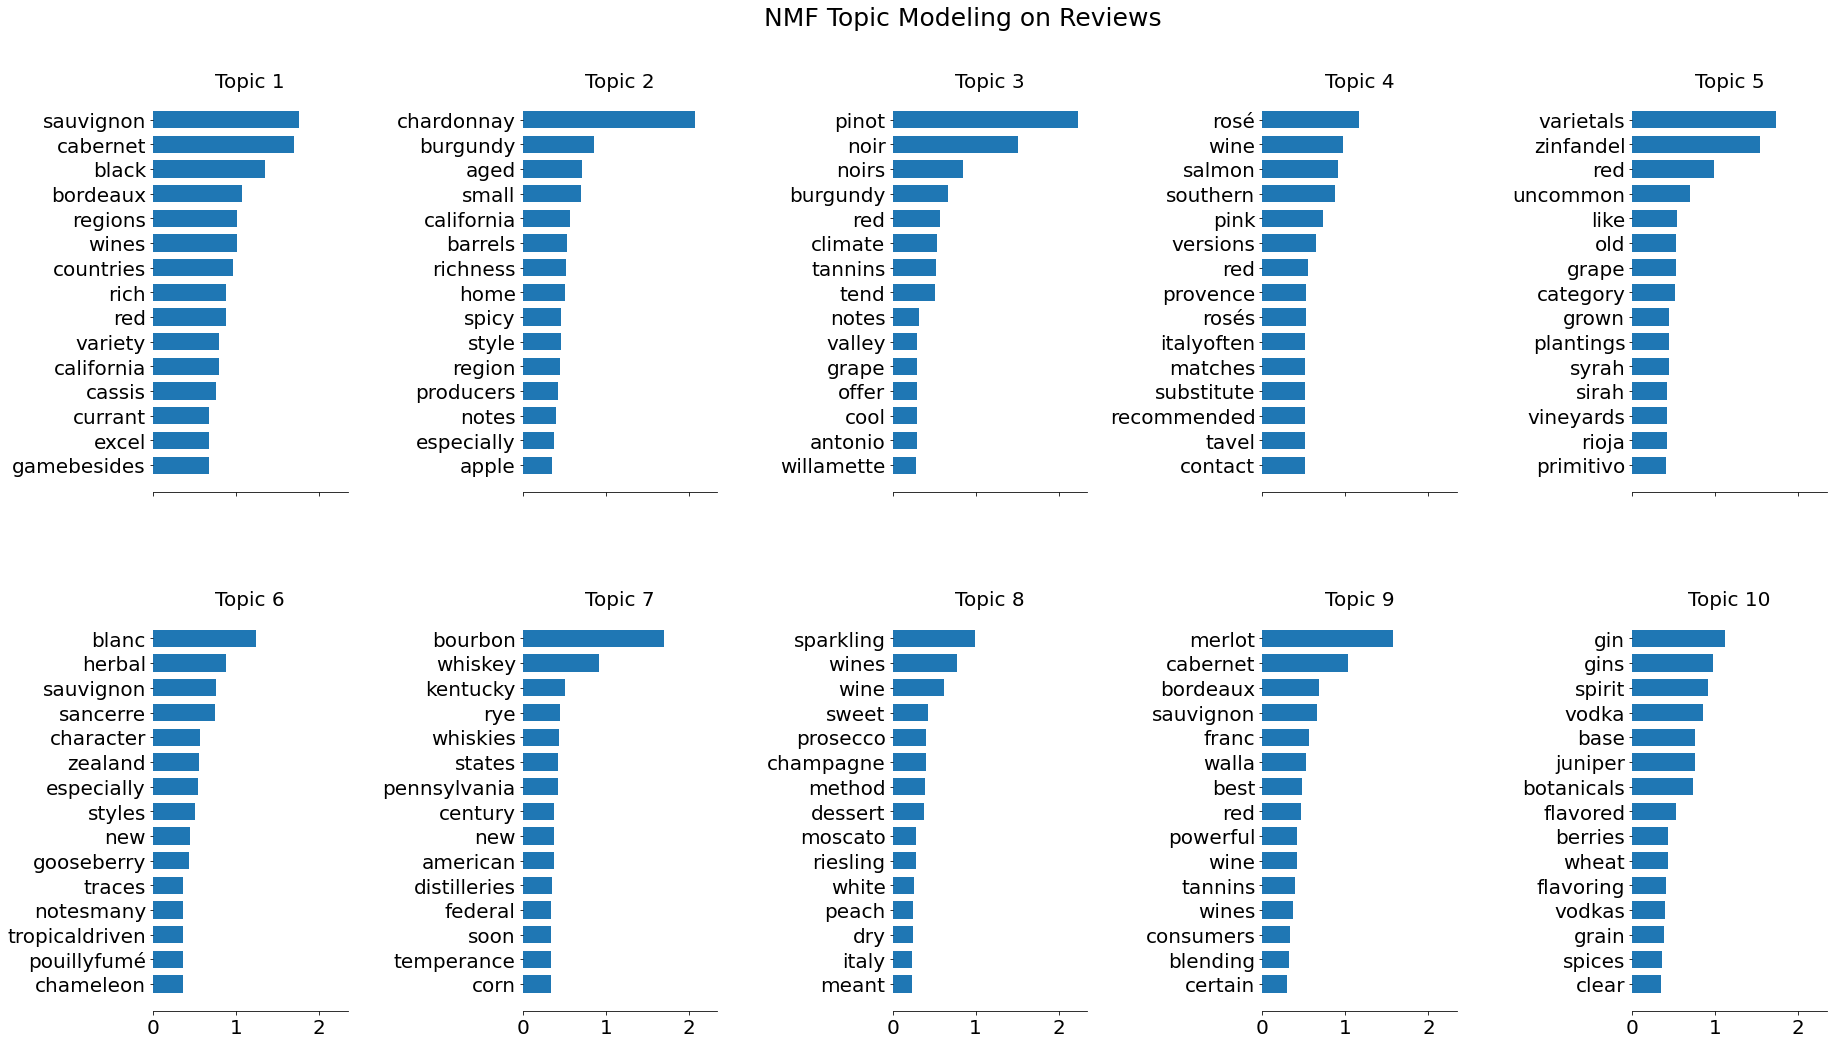

In [160]:
plot_top_words(nmf_review, reviews_vocabs, 15, "NMF Topic Modeling on Reviews")

### Topic exploration

#### Topic_0

In [162]:
for review in reviews_df.sort_values(by='topic_0', ascending=False).head(10)['Full_Review'].values:
    print(review)
    print('\n')
reviews_word_df.sort_values(by='topic_0', ascending=False).head(10).topic_0

black ruby color aromas of red cassis boysenberry strawberry black tea and bay with a satiny vibrant dryyetfruity mediumtofull body and a tingling compelling mediumlength cedar and tart cherry finish with moderate oak flavor a vibrant buoyant sonoma cabernet with great aging potential cabernet sauvignon is a variety that is the source of some of the worlds most celebrated and longestlived reds grown in many countries it is most famous in bordeaux where it is the principal grape in red bordeaux as well as in california  especially napa valley where it is labeled by its varietal namecabernet sauvignon has aromas and flavors of black currant cassis black cherry and sometimes plum in warmer regions or vintages quite rich on the palate the variety is very tannic giving its wines a bitter edge in their youth but also providing the wines with great aging potential with top flight examples drinking well for as long as four or five decades given their richness and flavor profile wines made from

sauvignon    1.76311
cabernet     1.69605
black        1.35635
bordeaux     1.06842
regions      1.01263
wines        1.01191
countries    0.96954
rich         0.88408
red          0.87748
variety      0.79969
Name: topic_0, dtype: float64

#### Topic_1

In [163]:
for review in reviews_df.sort_values(by='topic_1', ascending=False).head(10)['Full_Review'].values:
    print(review)
    print('\n')
reviews_word_df.sort_values(by='topic_1', ascending=False).head(10).topic_1

light gold color aromas and flavors of tea with lemon and thyme with a satiny crisp petillant fruity lighttomedium body and a smooth mediumlength finish displaying notes of pineapple and pastry with light oak flavor a bright foodfriendly chardonnay chardonnay is arguably the worlds most famous white variety thanks to its success in frances burgundy region as well as throughout much of california chardonnay on its own has rather straightforward pleasant aromas of apple and pear but when aged and sometimes fermented in small oak barrels the wines take on extra richness as well as notes of toasted almond vanilla and yeast the most renowned examples of chardonnay are from small villages and vineyards in burgundy such as chassagnemontrachet pulignymontrachet and meursault these wines are very powerful with ample spicy notes and very good acidity they age very well sometimes as long as  years another part of burgundy chablis is home to more restrained style of chardonnay certain areas of cal

chardonnay    2.07935
burgundy      0.85912
aged          0.71038
small         0.70710
california    0.56643
barrels       0.52808
richness      0.51675
home          0.50796
spicy         0.46022
style         0.45798
Name: topic_1, dtype: float64

#### Topic_2

In [164]:
for review in reviews_df.sort_values(by='topic_2', ascending=False).head(10)['Full_Review'].values:
    print(review)
    print('\n')
reviews_word_df.sort_values(by='topic_2', ascending=False).head(10).topic_2

light garnet color aromas and flavors of cherry lozenge spiced plum smoked mushrooms sesame and chocolate with a satiny crisp dryyetfruity light body and a polished mediumlength finish with moderate oak flavor a simple pinot noir with wide appeal pinot noir is one of the worlds most fascinating red varieties while many red grapes produces wines of power and youthful intensity a wine made from pinot noir is often more refined with higher acidity and lower levels of tannins the spiritual home for pinot noir is burgundy where it is produced in many styles from very light to examples that can age for two to three decades pinot noirs tend to have aromas and flavors red cherry fruit while some offer notes of wild strawberry plum or even floral notes such as carnation and red roses as tannins in pinot noir are not as pronounced as in a grape such as cabernet sauvignon or nebbiolo most pinot noirs can be enjoyed upon release which is usually two to three years after the vintage burgundy works 

pinot       2.23467
noir        1.51576
noirs       0.84479
burgundy    0.66819
red         0.56715
climate     0.53982
tannins     0.52420
tend        0.51201
notes       0.31501
valley      0.29808
Name: topic_2, dtype: float64

#### Topic_3

In [165]:
for review in reviews_df.sort_values(by='topic_3', ascending=False).head(10)['Full_Review'].values:
    print(review)
    print('\n')
reviews_word_df.sort_values(by='topic_3', ascending=False).head(10).topic_3

pink coral color aromas and flavors of watermelon candies cherry yogurt and white strawberry with a supple crisp dryish light body and a smooth breezy finish with no oak flavor a solid crisp rosé with a mild flavor profile rosé refers to a wine made when red grapes are given slight skin contact to produce a blush light copper salmon or pink color rosés range from bonedry to medium sweet and are made in most major wine producing countries among the most famous examples are tavel from frances rhone valley numerous offerings from provence in southern france as well as several excellent versions from puglia in southern italyoften thought of as a summer wine  in this case a substitute for red wine when the weather is hot  they can be enjoyed year round the drier versions of course are meat for food pairings recommended matches include chicken salad vegetables and seafood such as tuna or salmon especially with a rich rosé made from cabernet sauvignon or pinot noir


bright pink coral color a

rosé          1.16260
wine          0.97657
salmon        0.91293
southern      0.87005
pink          0.72557
versions      0.65096
red           0.55343
provence      0.52044
rosés         0.51881
italyoften    0.51704
Name: topic_3, dtype: float64

#### Topic_4

In [166]:
for review in reviews_df.sort_values(by='topic_4', ascending=False).head(10)['Full_Review'].values:
    print(review)
    print('\n')
reviews_word_df.sort_values(by='topic_4', ascending=False).head(10).topic_4

black garnet color aromas and flavors of red and black licorice roasted beets in pomegranate vinaigrette and minestrone with a satiny crisp fruity lighttomedium body and a tingling intriguing mediumlength finish with light oak flavor a rich and savory red for the table other red is a catchall category for both uncommon grape varietals and uncommon combinations of varietals there are little pockets of other red varietals grown throughout the us in california italian varietals such as barbera gignolino primitivo and nebbiolo and esoteric rhone varietals like cinsault and carignano can be found tempranillo best known as the principal red variety of spains rioja can also be found in small plantings in the southwest where hot grown conditions favor the grape many producers throughout the us produce blends of bordeaux with nonbordeaux varietals such as zinfandel petit sirah syrah and even hybrids like chambourcin that fall under our other us red category


ruby color aromas of grilled berrie

varietals    1.73321
zinfandel    1.54405
red          0.98046
uncommon     0.70025
like         0.53414
old          0.53152
grape        0.52240
category     0.51459
grown        0.44795
plantings    0.44718
Name: topic_4, dtype: float64

## Description topic modeling

In [168]:
df.head()

,Name,Description,Full_Review,Tasting_Info
0,Mezcal de Leyendas Verde San Luis Potosi Mezca...,Mezcal de Leyendas Review Verde San Luis Potos...,"Clear color. Aromas and flavors of cucumber, m...","Fruity, Funky, Rich, Spicy, Smoky, Herbal & Co..."
1,El Tesoro Paradiso Tequila Extra Anejo Mexico ...,El Tesoro Review Paradiso Tequila Extra Anejo ...,"Gold color. Inviting aromas of roasted nuts, c...","Fruity, Complex, Candied, Herbal, Rich & Spicy..."
2,Peloton de la Muerte Vegan Pechuga Mezcal Mexi...,Peloton de la Muerte Review Vegan Pechuga Mezc...,Silvery straw color. Citrusy aromas and flavor...,"Complex, Fruity & Herbal | pickled melon and p..."
3,El Tesoro Anejo Tequila Mexico Spirits,El Tesoro Review Anejo Tequila Mexico Mexican ...,Straw color. Inviting aromas and flavors of ho...,"Fruity, Spicy & Herbal | honey-drizzled grapef..."
4,1800 Milenio Extra Anejo Tequila Mexico Spirits,1800 Review Milenio Extra Anejo Tequila Mexico...,"Amber color. Aromas of toffee coated popcorn, ...","Fruity, Rich & Spicy | toffee coated popcorn, ..."


In [169]:
descriptions = df['Description'].fillna('')

descriptions = text_cleaning(descriptions)

tfidf_des = TfidfVectorizer(max_df=0.5, stop_words=stop_words)

des_matrix = tfidf_des.fit_transform(descriptions)

vocabs_des = tfidf_des.get_feature_names()

In [170]:
nmf_des = NMF(n_components=10)

nmf_des.fit(des_matrix)

des_matrix = nmf_des.transform(des_matrix)

des_df = pd.DataFrame(des_matrix).add_prefix('topic_')
des_df['Description'] = descriptions
des_df.head(10)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,Description
0,0.002195,0.057164,0.012126,0.000000,0.003552,0.000000,0.001616,0.000577,0.001027,0.001530,mezcal de leyendas review verde san luis potos...
1,0.001321,0.093576,0.009714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,el tesoro review paradiso tequila extra anejo ...
2,0.001371,0.050516,0.005971,0.000697,0.000745,0.001943,0.001979,0.005535,0.002941,0.009530,peloton de la muerte review vegan pechuga mezc...
3,0.003570,0.099551,0.000000,0.000000,0.004199,0.000000,0.000000,0.001181,0.000000,0.000000,el tesoro review anejo tequila mexico mexican ...
4,0.000000,0.095963,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,review milenio extra anejo tequila mexico mex...
5,0.000759,0.083324,0.003697,0.000736,0.002506,0.000000,0.002638,0.000399,0.000000,0.000000,el tesoro review blanco tequila mexico mexican...
6,0.001916,0.059040,0.009938,0.000000,0.001210,0.000000,0.001768,0.000000,0.000000,0.000000,mezcal de leyendas review cenizo durango mezca...
7,0.000000,0.072433,0.010199,0.000000,0.002463,0.000000,0.001102,0.000000,0.000000,0.000000,el tesoro review extra anejo tequila mexico me...
8,0.000000,0.101235,0.004875,0.000000,0.000000,0.000000,0.002294,0.000000,0.000000,0.000000,jose cuervo review reserva de la familia extra...
9,0.032113,0.056153,0.000000,0.000000,0.001361,0.000000,0.000000,0.000000,0.000000,0.001788,montelobos review ensamble joven mezcal mexico...


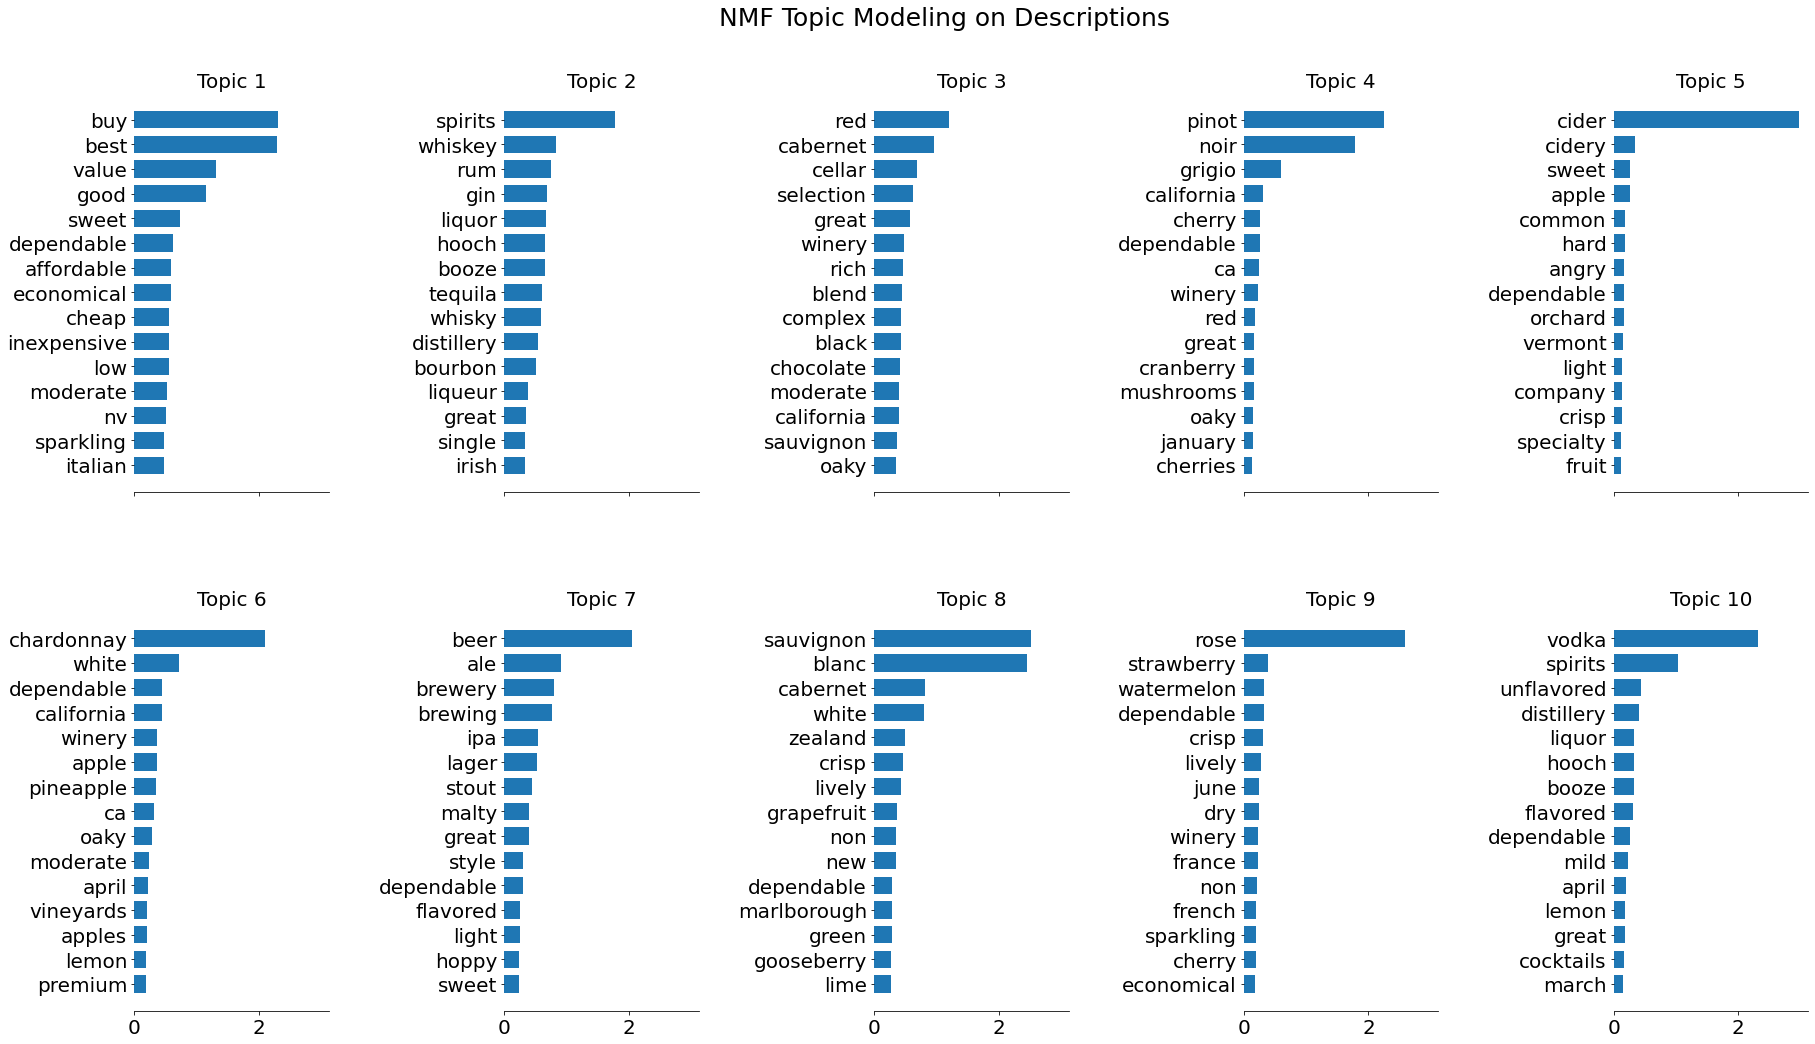

In [171]:
plot_top_words(nmf_des, vocabs_des, 15, "NMF Topic Modeling on Descriptions")

#### Topic_0

In [172]:
des_word_df = pd.DataFrame(nmf_des.components_.round(5), columns=vocabs_des).T.add_prefix('topic_')

In [173]:
for description in des_df.sort_values(by='topic_0', ascending=False).head(10)['Description'].values:
    print(description)
    print('\n')
des_word_df.sort_values(by='topic_0', ascending=False).head(10).topic_0

paluzzi review  italy italian wine moscato dasti sweet wine  sweet wine tasting note flavor description fruity juicy  smooth  non oaky smooth very sweet no oak honeysuckle and apple peach candies lemon sherbet and elderflower a sweet moscato pleaser silver medal december  rating   points inexpensive price cheap low priced prestige beverage group best buy best buy good value dependable wine producer dependable winery


bay bridge vineyards review white moscato nv ca california usa us wine california white moscato  white wine tasting note flavor description fruity juicy  smooth  quaffable smooth fruity sweet no oak apple candies ice pops a sweet white wine for value seekers bronze medal october  rating   points inexpensive price cheap low priced american the wine group best buy best buy good value


espritza review bubbly white wine nv italy italian wine other sparkling  sparkling wine tasting note flavor description crisp  lively fruity  juicy  smooth smooth fruity no oak candied pear a

buy            2.31187
best           2.28559
value          1.30695
good           1.15836
sweet          0.73229
dependable     0.61658
affordable     0.59318
economical     0.59268
inexpensive    0.55152
cheap          0.55152
Name: topic_0, dtype: float64

#### Topic_1

In [113]:
for description in des_df.sort_values(by='topic_1', ascending=False).head(10)['Description'].values:
    print(description)
    print('\n')
des_word_df.sort_values(by='topic_1', ascending=False).head(10).topic_1

boulder review straight bourbon whiskey co colorado usa us spirits straight bourbon whiskey  whisky spirits tasting note flavor description spicy warming dry engaging cedar popcorn roasted pecan nougat and banana cake cinnamon danish a bold craft whiskey that offers tasty notes of sweet cinnamon pastry silver medal december  rating   points premium price special occasion spendy american vapor distillery liquor booze hooch dependable spirits producer dependable distillery


capmaker review bourbon whiskey tx texas usa us spirits bourbon whiskey  whisky spirits tasting note flavor description mild warming dry cinnamon dusted pear hints of caramelized nuts dried cherry and honeycomb sourdough dulce de leche and black tea a mild bourbon that will play well in craft cocktails silver medal december  rating   points moderate price affordable economical american dynasty spirits liquor booze hooch dependable spirits producer dependable distillery


chicken cock review kentucky straight bourbon 

spirits       1.92816
whiskey       0.83316
vodka         0.77918
liquor        0.72847
booze         0.72089
hooch         0.72089
distillery    0.61057
whisky        0.60359
gin           0.55755
rum           0.52025
Name: topic_1, dtype: float64

#### Topic_2

In [114]:
for description in des_df.sort_values(by='topic_2', ascending=False).head(10)['Description'].values:
    print(description)
    print('\n')
des_word_df.sort_values(by='topic_2', ascending=False).head(10).topic_2

vineyard  review cabernet sauvignon  ca california usa us wine diamond mountain napa valley cabernet sauvignon  red wine tasting note flavor description fruity juicy  smooth oaky rich  full  spicy  complex warming dry yet fruity heavy oak complex marinated beets and beans cranberry dark chocolate nutmeg and menthol fine leather chocolate gelato and plum a creamy velvety cabernet with appetizing savory elements and fruity center delicious gold medal cellar selection march  rating   points luxury price expensive high priced american vineyard  cellar selection great wine producer great winery


crux winery review gsm red blend  ca california usa us wine russian river valley gsm blend red  red wine tasting note flavor description fruity oaky rich  full spicy  complex  juicy  smooth warming dry yet fruity moderate oak interesting red velvet cake ripe plum and cherry sorbet ripe berries sage spiced apple black tea licorice and black pepper a charming rhone varietal blend with excellent food 

red          1.25438
wine         1.05654
cabernet     0.90894
cellar       0.61606
selection    0.56487
fruity       0.54372
great        0.52528
winery       0.47673
rich         0.47473
blend        0.46112
Name: topic_2, dtype: float64

#### Topic_3

In [115]:
for description in des_df.sort_values(by='topic_3', ascending=False).head(10)['Description'].values:
    print(description)
    print('\n')
des_word_df.sort_values(by='topic_3', ascending=False).head(10).topic_3

love noir review pinot noir  ca california usa us wine california pinot noir  red wine tasting note flavor description fruity juicy  smooth  oaky tingling dryish moderate oak candied cherries cranberry tart maple and french toast same as aromas with notes of charred oak an easy pinot noir for the table silver medal november  rating   points moderate price affordable economical american the wine group


love noir review pinot noir  ca california usa us wine california pinot noir  red wine tasting note flavor description fruity juicy  smooth  oaky tingling dryish moderate oak candied cherries cranberry tart maple and french toast same as aromas with notes of charred oak an easy pinot noir for the table silver medal november  rating   points moderate price affordable economical american the wine group


imagery estate review pinot noir  ca california usa us wine california pinot noir  red wine tasting note flavor description fruity juicy  smooth  oaky smooth fruity a suggestion of oak roa

pinot         2.44163
noir          1.83210
grigio        0.81446
wine          0.55939
smooth        0.31023
california    0.29649
dependable    0.27642
fruity        0.26485
cherry        0.24925
ca            0.23245
Name: topic_3, dtype: float64

#### Topic_4

In [50]:
for description in des_df.sort_values(by='topic_4', ascending=False).head(10)['Description'].values:
    print(description)
    print('\n')
des_word_df.sort_values(by='topic_4', ascending=False).head(10).topic_4

wards cider review cherry cider canada canadian cider fruit cider  cider cider tasting note flavor description sweet  fruity smooth off dry coconut confection toasted almond and candied cherry same as aromas with accents of strawberry soda a fruity and nutty cider thats easy to love gold medal april  rating  points price wards cider dependable cider producer dependable cidery


common cider company review blackberry sangria hard cider ca california usa us cider fruit cider  cider cider tasting note flavor description spicy  complex  crisp  light normal dry yet fruity charming ripe mulberry cherry jam mint jellies pepper and lavender same as aromas with notes of kiwi and dark fruit leather and minerals a dry but fruity cider that will appeal to pinot noir drinkers delightful to pair silver medal october  rating  points price american common cider company dependable cider producer dependable cidery


common cider company review blackberry sangria hard cider ca california usa us cider fru

cider         2.83307
cidery        0.32391
beer          0.29968
apple         0.27363
dependable    0.21667
sweet         0.19137
common        0.18860
hard          0.18376
company       0.17600
light         0.16621
Name: topic_4, dtype: float64

In [174]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8319 entries, 0 to 8318
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Name          8319 non-null   object
 1   Description   8319 non-null   object
 2   Full_Review   7274 non-null   object
 3   Tasting_Info  8319 non-null   object
dtypes: object(4)
memory usage: 325.0+ KB


## Tasting Info topic modeling

In [175]:
tasting_infos = df['Tasting_Info'].fillna('')

tasting_infos = text_cleaning(tasting_infos)

tfidf_tas = TfidfVectorizer(max_df=0.8, stop_words=stop_words)

tas_matrix = tfidf_tas.fit_transform(tasting_infos)

vocabs_tas = tfidf_tas.get_feature_names()

nmf_tas = NMF(n_components=10)

nmf_tas.fit(tas_matrix)

tas_matrix = nmf_tas.transform(tas_matrix)

tas_df = pd.DataFrame(tas_matrix).add_prefix('topic_')
tas_df['Description'] = tasting_infos
tas_df.head(10)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,Description
0,0.000135,0.002783,0.000000,0.077486,0.000000,0.000000,0.026414,0.000000,0.000000,0.028718,fruity funky rich spicy smoky herbal complex ...
1,0.000000,0.001104,0.000000,0.126803,0.002848,0.000000,0.011525,0.000000,0.000000,0.019221,fruity complex candied herbal rich spicy roa...
2,0.000000,0.015173,0.002974,0.081904,0.000000,0.007974,0.008671,0.014057,0.001939,0.000996,complex fruity herbal pickled melon and pine...
3,0.000000,0.002390,0.000000,0.101995,0.000000,0.000000,0.031326,0.003981,0.000000,0.000000,fruity spicy herbal honeydrizzled grapefruit...
4,0.000000,0.000000,0.000487,0.084892,0.000000,0.000000,0.011320,0.000000,0.000000,0.001051,fruity rich spicy toffee coated popcorn pean...
5,0.000000,0.000092,0.000000,0.074139,0.000714,0.000000,0.004045,0.012921,0.000164,0.034017,complex mild spicy marinated olives and pepp...
6,0.000000,0.000000,0.000000,0.092400,0.000000,0.024232,0.011179,0.000000,0.000000,0.021033,fruity complex herbal rich smoky sweet chile...
7,0.000000,0.000000,0.000000,0.055774,0.000000,0.000000,0.035718,0.000000,0.000000,0.030763,complex fruity rich spicy olive and hard che...
8,0.000000,0.000000,0.000000,0.133269,0.014651,0.000000,0.000000,0.000000,0.000000,0.004081,spicy rich molasses roasted figs honey cake ...
9,0.000000,0.000000,0.000000,0.062290,0.004861,0.013037,0.011718,0.000000,0.001851,0.005557,funky spicy sweet tea gunpowder grilled gree...


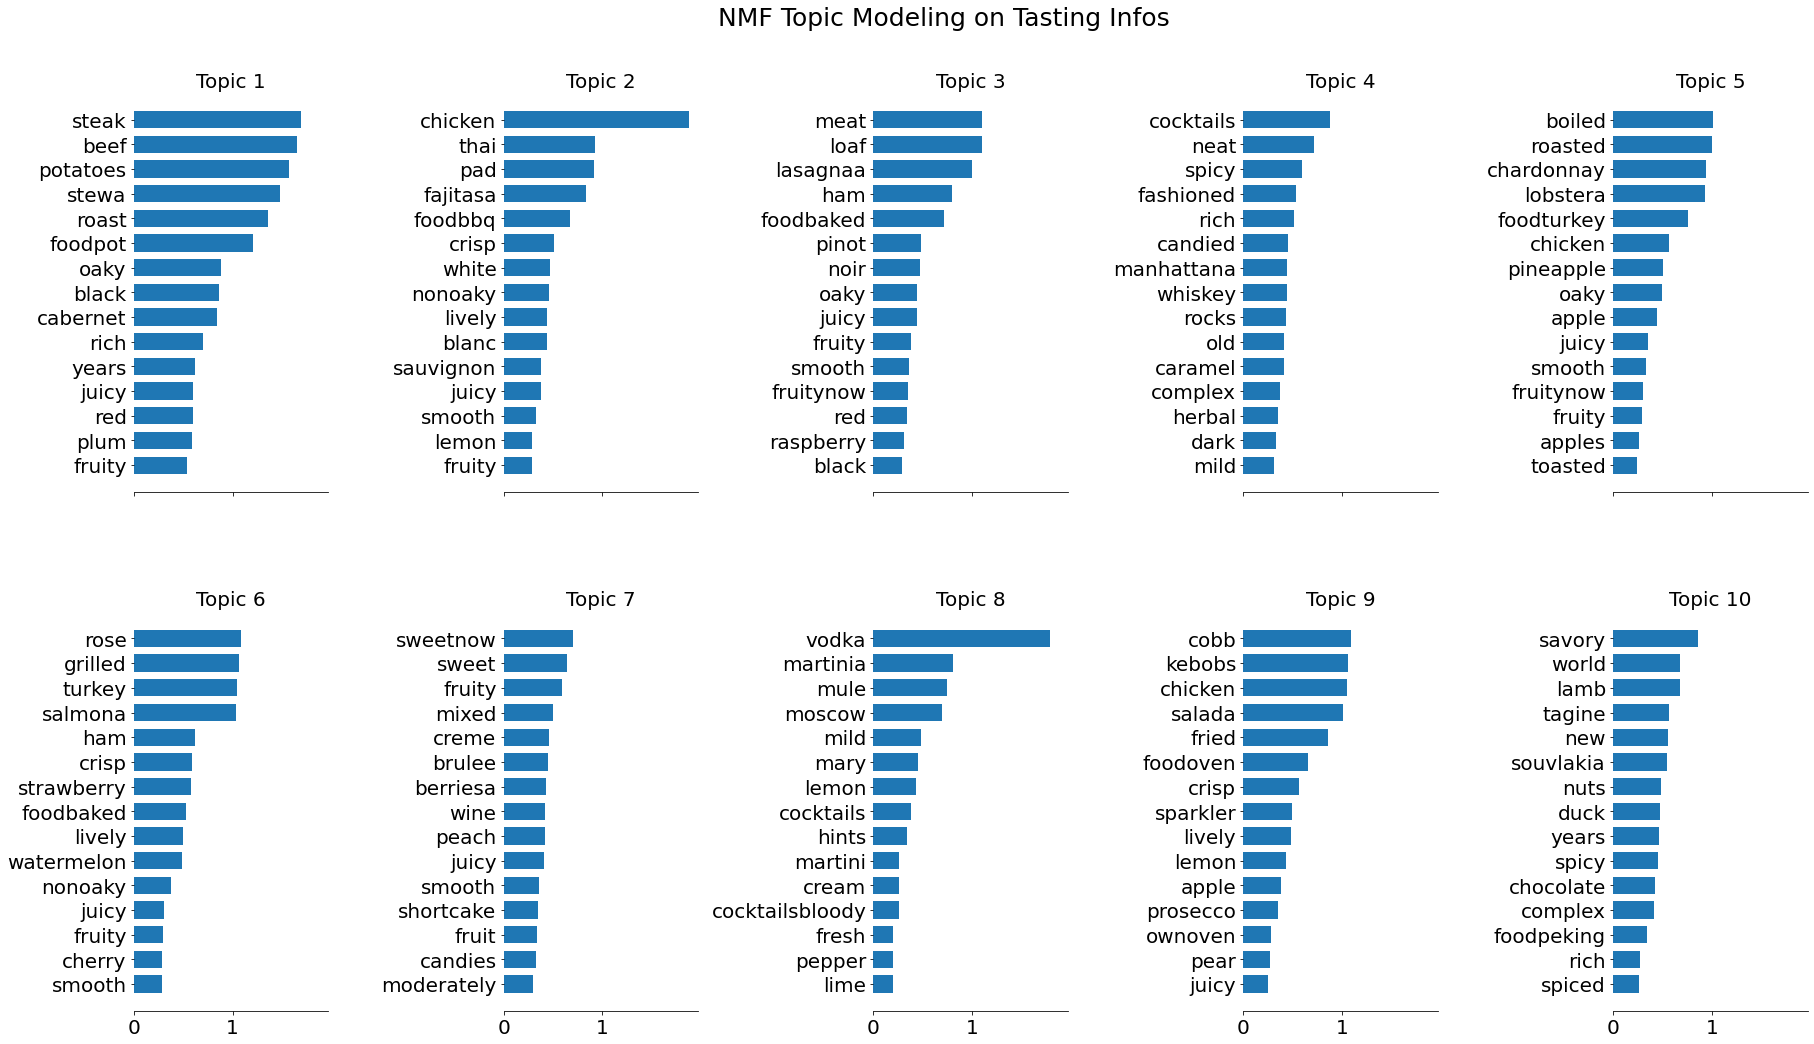

In [176]:
plot_top_words(nmf_tas, vocabs_tas, 15, "NMF Topic Modeling on Tasting Infos")